In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
import sys
from scipy.stats import linregress

In [2]:
from config_account_reader import ConfigAccountReader
config_accout_reader = ConfigAccountReader('config_account.yaml')
exchange_name = config_accout_reader.get_exchange_name()
symbol = config_accout_reader.get_market_symbol()
public_key = config_accout_reader.get_public_key()
secret = config_accout_reader.get_secret_key()

# I need the exchange 

#### https://docs.ccxt.com/en/latest/manual.html#configuring-api-keys

In [3]:
# from variable id
exchange_id = exchange_name
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({
    'apiKey': public_key,
    'secret': secret,
})

In [4]:
from config_strategy_reader import ConfigStrategyReader
config_strategy_reader = ConfigStrategyReader('config_strategy.yaml')

position_size = config_strategy_reader.get_position_size()
check_orders_frequency = config_strategy_reader.get_check_orders_frequency()
closed_order_status = config_strategy_reader.get_closed_order_status()

num_buy_grid_lines = config_strategy_reader.get_num_buy_grid_lines()
num_sell_grid_lines = config_strategy_reader.get_num_sell_grid_lines()
grid_size = config_strategy_reader.get_grid_size()

In [5]:
markets = exchange.load_markets()
symbols = [item for item in markets if item.endswith('USDT')]
print(f'Amount of pair of market: {len(symbols)}')

Amount of pair of market: 415


#### Time stamps for stepping back in time

In [6]:
days = 1
weeks = 4
now = datetime.now()
back = now - timedelta(days=days)
back_timestamp = int(back.timestamp()*1000)
print(f'now: {now} minus weeks: {weeks} is back time: {back}\nback timestamp is {back_timestamp}')

now: 2022-12-03 08:03:31.918650 minus weeks: 4 is back time: 2022-12-02 08:03:31.918650
back timestamp is 1669964611918


#### Set pair == market

In [7]:
for_pair = 'BTC/USDT'

### Get all ohlcv for pair - function

In [8]:
def get_all_ohlcv_for_pair(for_pair, since):
    period = '1m'
    all_ohlcv = []
    
    ohlcv = exchange.fetch_ohlcv(for_pair, period, since=since, limit=1000)
    all_ohlcv.extend(ohlcv)
    
    while(len(ohlcv)==1000):
        since_time_stamp = ohlcv[-1][0]
        ohlcv = exchange.fetch_ohlcv(symbol, period, since=since_time_stamp, limit=1000)
        all_ohlcv.extend(ohlcv)
        
    return all_ohlcv

In [9]:
def make_data_frame(ohlcv):
    df = pd.DataFrame(ohlcv)
    df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.set_index('Time', inplace=True)
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.astype(float)
    
    return df

In [10]:
def get_slope_intercept_std_err(df):
    
    slope, intercept, r_value, p_value, std_err = linregress(x=df['Number'], y=df['Close'])
    print(f'slope: {slope},\n'
          f'intercept: {intercept},\n'
          f'r_value: {r_value},\n'
          f'p_value: {p_value},\n'
          f'std_err: {std_err}')
    df['Closetrend'] = slope * df['Number'] + intercept
    
    return slope, intercept, std_err
    

# The main

In [11]:
import mplfinance as mpf

In [12]:
ohlcv = get_all_ohlcv_for_pair(symbol, back_timestamp)
df = make_data_frame(ohlcv)
print(df)

                         Open      High       Low     Close     Volume
Time                                                                  
2022-12-02 07:04:00  16911.31  16917.37  16907.42  16916.56  104.69510
2022-12-02 07:05:00  16916.82  16921.60  16916.18  16920.07  119.27732
2022-12-02 07:06:00  16920.07  16923.68  16916.20  16918.87  150.06584
2022-12-02 07:07:00  16918.87  16922.68  16914.42  16921.77   99.21630
2022-12-02 07:08:00  16921.77  16924.82  16919.85  16921.89   84.03993
...                       ...       ...       ...       ...        ...
2022-12-03 06:59:00  16980.56  16983.85  16975.86  16976.72   88.09920
2022-12-03 07:00:00  16976.11  16982.02  16975.41  16980.38  115.36284
2022-12-03 07:01:00  16980.38  16983.51  16980.02  16981.21   65.85569
2022-12-03 07:02:00  16981.21  16984.33  16980.73  16981.86   43.77883
2022-12-03 07:03:00  16981.86  16982.56  16978.06  16980.04   50.43980

[1441 rows x 5 columns]


C:\Users\Romek\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


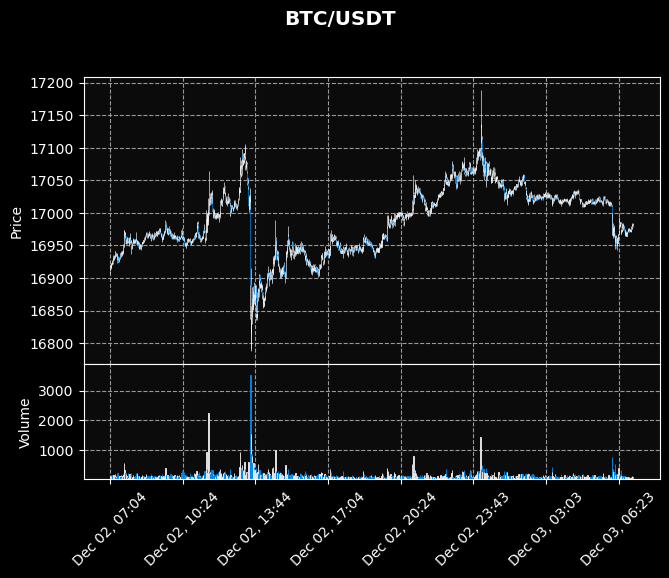

In [13]:
mpf.plot(df, type='candle', volume=True, title=for_pair, style='nightclouds')


#### Analysis of the maximum, minimum and density of price levels

In [14]:
all_values = []

In [15]:
all_values.extend(df.Open.values)
all_values.extend(df.High.values)
all_values.extend(df.Low.values)
all_values.extend(df.Close.values)

In [16]:
df_all_values = pd.DataFrame(data=all_values)

In [17]:
df_all_values.value_counts()

17020.00    10
17022.00     9
16960.00     7
17018.00     6
16944.97     6
            ..
16966.56     1
16966.63     1
16966.69     1
16966.79     1
17188.98     1
Length: 4050, dtype: int64

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

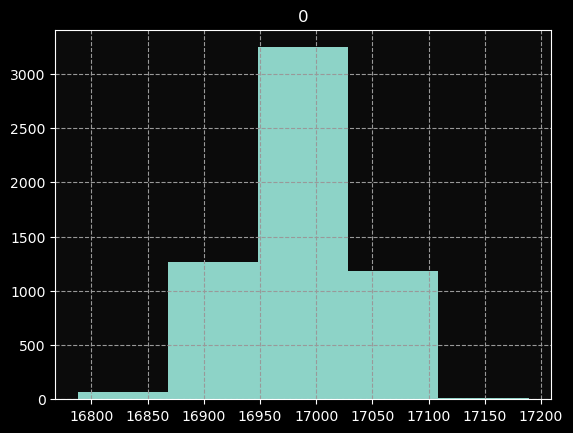

In [24]:
df_all_values.hist(bins=5)

In [19]:
import numpy as np

In [20]:
count, division = np.histogram(all_values)

In [21]:
count

array([   3,   62,  209, 1053, 1543, 1701,  961,  221,   10,    1],
      dtype=int64)

In [22]:
division

array([16787.85 , 16827.963, 16868.076, 16908.189, 16948.302, 16988.415,
       17028.528, 17068.641, 17108.754, 17148.867, 17188.98 ])